# Multiple PubMed Diabetes visualizations
In this tutorial, we will visualize the PubMed Diabetes graph using all of the available embedding methods that can embed PubMed Diabetes.

This will exclude methods that require edge types and weights.

## Retrieving the graph

In [1]:
from grape.datasets.linqs import PubMedDiabetes
graph = PubMedDiabetes()

In this version of PubMed Diabetes, we have integrated the words data.

Generally, in the embedding of PubMed Diabetes, the words information is excluded and used in classifier models down the line.

In [2]:
from grape.datasets.linqs import get_words_data

graph, _ = get_words_data(graph)

We drop the singleton nodes:

In [3]:
graph = graph.remove_disconnected_nodes()

To get the graph report, just run:

In [4]:
graph

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>PubMedDiabetes</h2><p class="paragraph">The undirected graph PubMedDiabetes has 19.72K heterogeneous nodes and 44.33K edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 1.70MB and 165.52KB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 1, the maximum node degree is 171, the mode degree is 1, the mean degree is 4.50 and the node degree median is 2.</p><p class="paragraph">The nodes with the highest degree centrality are 9742976 (degree 171 and node type Diabetes Mellitus Type 2), 8366922 (degree 154 and node type Diabetes Mellitus Type 1), 11832527 (degree 131 and node type Diabetes Mellitus Type 2), 19479186 (degree 130 and node type Diabetes Mellitus Type 2) and 18776148 (degree 125 and node type Diabetes Mellitus Type 1).</p><h3 style="margin: 1em 0 0 0;">Node types</h3><p class="paragraph">The graph has 3 node types, which are Diabetes Mellitus Type 1 (7.88K nodes, 39.94%), Diabetes Mellitus Type 2 (7.74K nodes, 39.25%) and Diabetes Mellitus, Experimental (4.10K nodes, 20.81%). The RAM requirement for the node types data structure is 1.03MB.</p><h3 style="margin: 1em 0 0 0;">Topological Oddities</h3><p class="paragraph">A topological oddity is a set of nodes in the graph that <i>may be derived</i> by an error during the generation of the edge list of the graph and, depending on the task, could bias the results of topology-based models. In the following paragraph, we will describe the detected topological oddities.</p><h4 style="margin: 1em 0 0 0;">Isomorphic node groups</h4><p class="paragraph">Isomorphic groups are nodes with exactly the same neighbours and node types (if present in the graph). Nodes in such groups are topologically indistinguishable, that is swapping their ID would not change the graph topology. We have detected 4 isomorphic node groups in the graph, involving a total of 8 nodes (0.04%) and 62 edges (0.07%). The detected isomorphic node groups, sorted by decreasing size, are:</p><ol class="medium-columns"><li><p class="paragraph">Group with 2 nodes (degree 12 and node type Diabetes Mellitus, Experimental): 17200690 and 18430060.</p></li>
<li><p class="paragraph">Group with 2 nodes (degree 7 and node type Diabetes Mellitus, Experimental): 2662016 and 2662408.</p></li>
<li><p class="paragraph">Group with 2 nodes (degree 6 and node type Diabetes Mellitus Type 2): 17387446 and 17509069.</p></li>
<li><p class="paragraph">Group with 2 nodes (degree 6 and node type Diabetes Mellitus, Experimental): 3156405 and 2952656.</p></li></ol><h4 style="margin: 1em 0 0 0;">Dendritic trees</h4><p class="paragraph">A dendritic tree is a tree-like structure starting from a root node that is part of another strongly connected component. We have detected 69 dendritic trees in the graph, involving a total of 507 nodes (2.57%) and 507 edges (0.57%), with the larg

## Sorting the graph by decreasing node degree
Some of the TensorFlow embedding models use the TensorFlow NCE method, which requires the nodes to be sorted by occurrence.

In [5]:
graph = graph.sort_by_decreasing_outbound_node_degree()

## Splitting into training and test set

In [6]:
train, test = graph.get_node_label_holdout_graphs(train_size=0.7)
train.enable()

## Retrieving the available embedding methods

In [7]:
from grape import get_available_models_for_node_embedding

all_embedding_methods = get_available_models_for_node_embedding()
embedding_methods = all_embedding_methods[
    (~all_embedding_methods.requires_edge_types.astype(bool)) &
    (~all_embedding_methods.requires_edge_weights.astype(bool))
]

# We remove some models that either require some additional
# information or are simply currently work in progress.
embedding_methods = embedding_methods[
    ~embedding_methods.model_name.str.contains("SPINE") &
    ~embedding_methods.model_name.str.contains("WINE")
]

## Running the visualizations

Computing embedding:   0%|          | 0/36 [00:00<?, ?it/s]

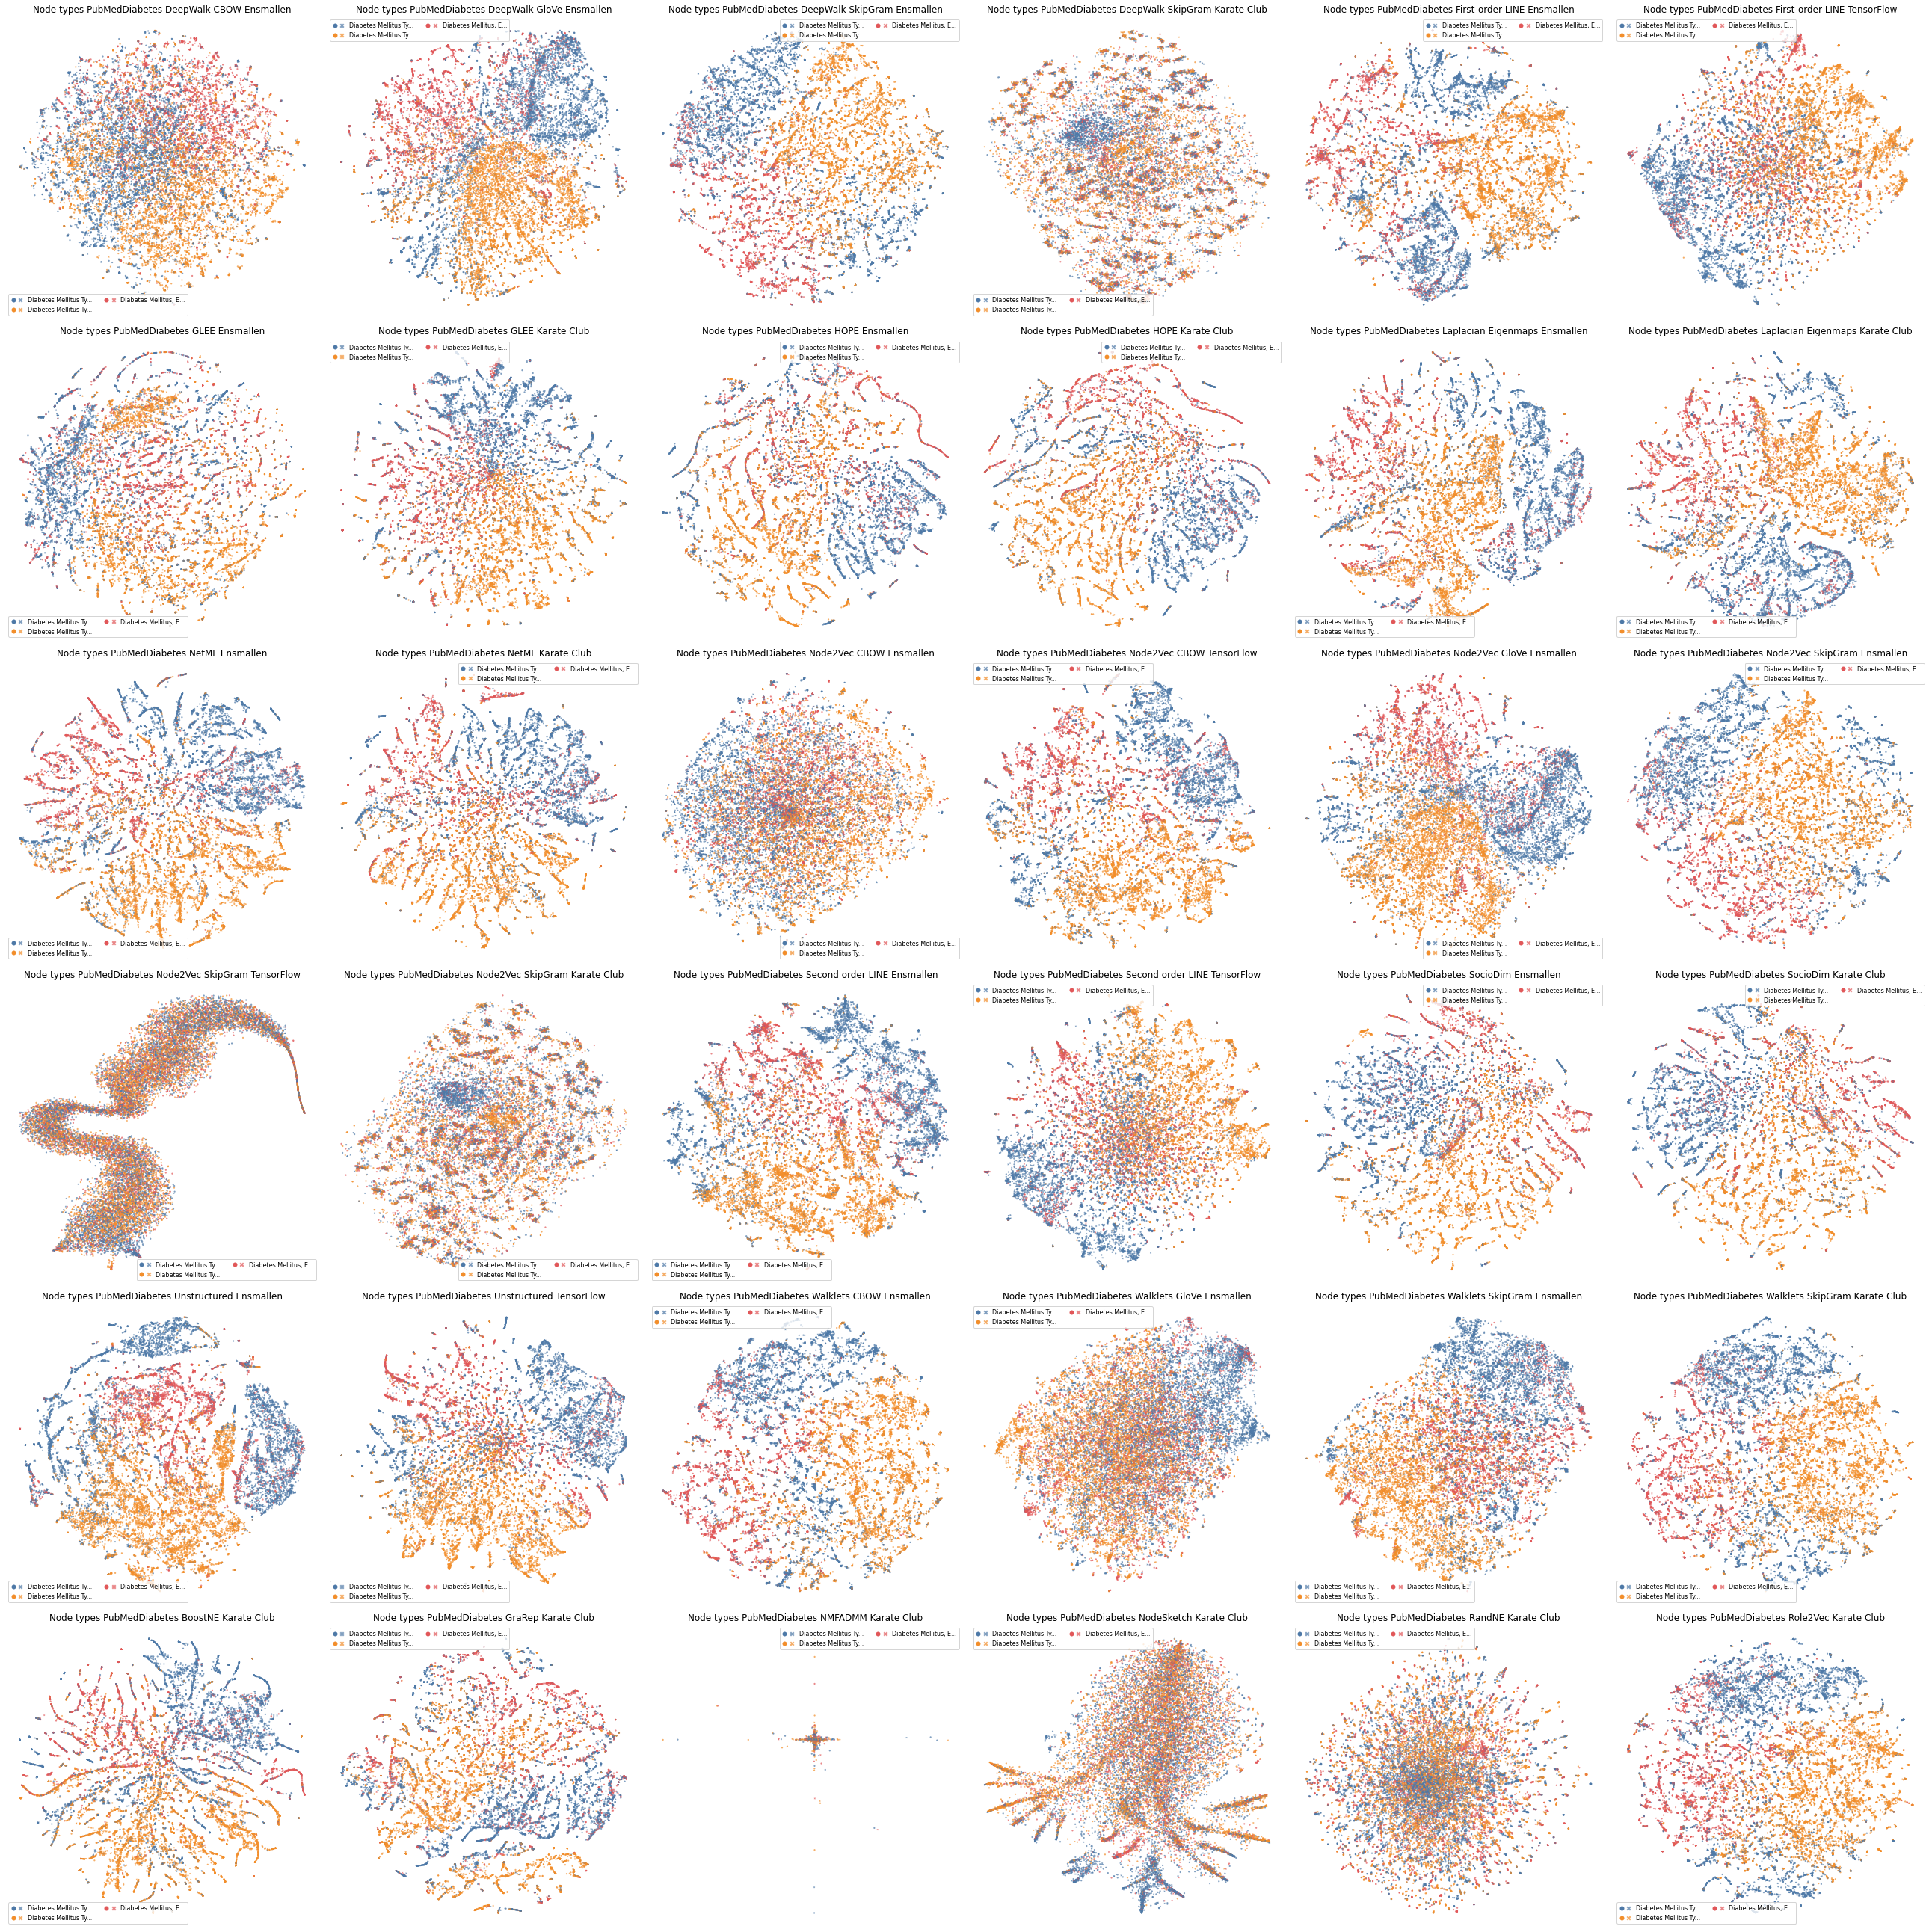

In [8]:
import silence_tensorflow.auto
from grape import GraphVisualizer
from grape.utils import AbstractEmbeddingModel
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from math import ceil

ncols = 6
nrows = ceil(embedding_methods.shape[0] / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

for index, (_, row) in tqdm(
    enumerate(embedding_methods.iterrows()),
    total=embedding_methods.shape[0],
    desc="Computing embedding"
):
    model = AbstractEmbeddingModel.get_model_from_library(
        model_name=row.model_name,
        library_name=row.library_name
    )(enable_cache=True)
    embedding = model.fit_transform(train)
    vis = GraphVisualizer(
        graph,
        node_embedding_method_name=f"{row.model_name} {row.library_name}",
        automatically_display_on_notebooks=False
    )
    vis.fit_nodes(embedding)
    vis.plot_node_types(
        figure=fig,
        axes=axes[index // ncols, index % ncols],
        train_indices=train.get_node_ids_with_known_node_types(),
        test_indices=test.get_node_ids_with_known_node_types()
    )
fig.tight_layout()
plt.show()